# Oversmoothing Analysis of Node Classification

### Setup

In [1]:
import os

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.utils import add_remaining_self_loops, degree
from torch_scatter import scatter
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv, GATConv, SimpleConv
from torch_geometric.datasets import HeterophilousGraphDataset
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Custom definitions

from models.gcn import GCN
from models.gat import GAT

from utils.trainer import Trainer

#### 1) Find and Download Datasets for Node Classification dataset link

***Roman Empire***

* Based on the Roman Empire article from Wikipedia
* Each node corresponds to a word in the text
* Each word is connected to another if the word follows or there is a dependency within the sentence
* The class of the node is its syntactic role found using spaCy
* Node features are fastText word embeddings

In [4]:
rome = HeterophilousGraphDataset(root='data/', name='Roman-empire')

***Amazon Ratings***

* Nodes are products
* Edges connect products frequently bought together
* Predict binned average rating
* Features are mean of text embeddings of product descriptions

In [16]:
amazon = HeterophilousGraphDataset(root='data/', name='Amazon-ratings')

***Minesweeper***

* 100x100 grid
* Each cell is connected to its eight neighbors
* Mines vs not mines
  * Binary classes
  * 20% are mines
* Node features are one-hot-encoded numbers of neighboring mines

In [3]:
minesweeper = HeterophilousGraphDataset(root='data/', name='Minesweeper')

***Tolokers***

In [8]:
tolo = HeterophilousGraphDataset(root='data/', name='Tolokers')

***Questions***

In [9]:
questions = HeterophilousGraphDataset(root='data/', name='Questions')

### 2) Code GNN-based models and obtain node classification performance
* Define GCN
* Get baseline results

### 3) Change the Message-passing layer and obtain performance for each layer
* Test different message-passing layers
* Test different number of layers

In [ ]:
all_results = {
    "GCN": dict(),
    "GAT": dict(),
}

In [56]:
dataset = rome.to(device)

conv_channels_list = [256, 256, 256]
mlp_channels_list = [128, 128]
num_heads = 4

model = GCN(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
).to(device)

trainer = Trainer(model, dataset)

print(f"Number of parameters: {trainer.get_num_params():,}")

trainer.run(1000)

Number of parameters: 542,226
Epoch 000, Loss: 2.8497, Train Acc: 0.1226, Val Acc: 0.1190, Test Acc: 0.1211
Epoch 050, Loss: 2.6972, Train Acc: 0.1567, Val Acc: 0.1543, Test Acc: 0.1548
Epoch 100, Loss: 2.6121, Train Acc: 0.2069, Val Acc: 0.2018, Test Acc: 0.2026
Epoch 150, Loss: 2.5224, Train Acc: 0.2551, Val Acc: 0.2500, Test Acc: 0.2481
Epoch 200, Loss: 2.4280, Train Acc: 0.2797, Val Acc: 0.2756, Test Acc: 0.2764
Epoch 250, Loss: 2.3410, Train Acc: 0.3012, Val Acc: 0.2964, Test Acc: 0.2995
Epoch 300, Loss: 2.2590, Train Acc: 0.3233, Val Acc: 0.3147, Test Acc: 0.3203
Epoch 350, Loss: 2.1685, Train Acc: 0.3612, Val Acc: 0.3463, Test Acc: 0.3512
Epoch 400, Loss: 2.0792, Train Acc: 0.4131, Val Acc: 0.4011, Test Acc: 0.3985
Epoch 450, Loss: 1.9780, Train Acc: 0.4564, Val Acc: 0.4418, Test Acc: 0.4400
Epoch 500, Loss: 1.8620, Train Acc: 0.4899, Val Acc: 0.4715, Test Acc: 0.4700
Epoch 550, Loss: 1.7605, Train Acc: 0.5161, Val Acc: 0.4971, Test Acc: 0.4977
Epoch 600, Loss: 1.6732, Train Acc

In [60]:
trainer.run(300, 20)

Epoch 000, Loss: 0.4564, Train Acc: 0.9333, Val Acc: 0.7333, Test Acc: 0.7324
Epoch 020, Loss: 0.4555, Train Acc: 0.9350, Val Acc: 0.7327, Test Acc: 0.7312
Epoch 040, Loss: 0.4524, Train Acc: 0.9364, Val Acc: 0.7333, Test Acc: 0.7328
Epoch 060, Loss: 0.4412, Train Acc: 0.9401, Val Acc: 0.7326, Test Acc: 0.7333
Epoch 080, Loss: 0.4357, Train Acc: 0.9415, Val Acc: 0.7350, Test Acc: 0.7326
Epoch 100, Loss: 0.4255, Train Acc: 0.9427, Val Acc: 0.7333, Test Acc: 0.7351
Epoch 120, Loss: 0.4228, Train Acc: 0.9458, Val Acc: 0.7336, Test Acc: 0.7347
Epoch 140, Loss: 0.4076, Train Acc: 0.9463, Val Acc: 0.7343, Test Acc: 0.7349
Epoch 160, Loss: 0.4085, Train Acc: 0.9488, Val Acc: 0.7324, Test Acc: 0.7337
Epoch 180, Loss: 0.3983, Train Acc: 0.9494, Val Acc: 0.7361, Test Acc: 0.7346
Epoch 200, Loss: 0.3947, Train Acc: 0.9524, Val Acc: 0.7343, Test Acc: 0.7354
Epoch 220, Loss: 0.3838, Train Acc: 0.9541, Val Acc: 0.7329, Test Acc: 0.7353
Epoch 240, Loss: 0.3774, Train Acc: 0.9551, Val Acc: 0.7320, Tes

In [61]:
trainer.get_metrics()

(0.7336745499470526,
 0.7348622946298925,
 0.7336745499470526,
 0.7301796260025921,
 0.9493528372573874)

### 4) Analyze the relationship between the number of message-passing layers and the node classification performance
* Visualize oversmoothing

In [ ]:
class Analyzer:
    def __init__(self):
        self.tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

    def fit_tsne(self, data):
        self.tsne.

In [ ]:
# Load model from file
model = GAT(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

model.load_state_dict(torch.load(weights_path, weights_only=True))

<All keys matched successfully>

In [62]:
loader = DataLoader(dataset, batch_size=1) #shuffle=True)

batch = next(iter(loader))
with torch.no_grad():
    logits, embeddings = model(batch.x, batch.edge_index, return_emb=True)

predictions = logits.argmax(dim=1)
predictions

tensor([ 3, 10,  6,  ...,  4,  4,  8], device='cuda:0')

In [63]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

emb_2d = []

for i, emb in enumerate(embeddings):
    emb_2d.append(tsne.fit_transform(emb.cpu().numpy()))

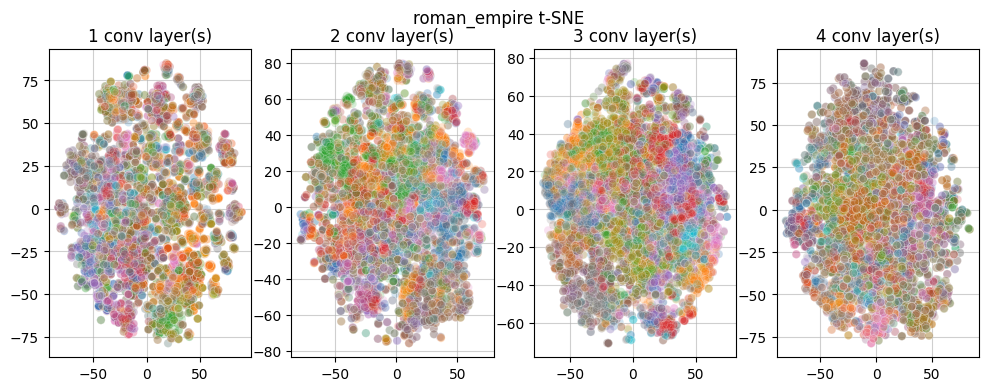

In [64]:
def plot_tsne(emb_2d, legend=True):
    n_emb = len(emb_2d)

    labels = dataset.y.cpu()

    fig, axes = plt.subplots(1, n_emb, figsize=(12, 4))

    for i, ax in enumerate(axes):

        end = 10000
        data = emb_2d[i][:end]

        x = data[:, 0]
        y = data[:, 1]

        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels[:end], ax=ax, alpha=0.2, palette="tab10")
                        
        ax.set_title(f"{i + 1} conv layer(s)")
        if not legend:
            ax.get_legend().remove()
        ax.set_axisbelow(True)
        ax.grid(alpha=0.6)

    plt.suptitle(f"{dataset.name} t-SNE")

    plt.show()

plot_tsne(emb_2d, legend=False)